<a href="https://colab.research.google.com/github/cianadeveau/MechInterp/blob/main/Factual_Circuits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring the circuit underlying country-capital facts

In [ ]:
pip install transformer_lens

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.0/192.0 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 117.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.5 MB/s eta 0:00:00


In [ ]:
import transformer_lens as tl
from transformer_lens import HookedTransformer
import torch
import einops
from jaxtyping import Float, Int
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import torch.nn.functional as F

## Functions

In [ ]:
def patch_attention_head(layer, head, clean_cache, corrupted_cache):
    """Patch a specific attention head's output"""
    def head_patch_hook(activation, hook):
        # activation shape: [batch, seq_len, n_heads, d_head]
        # Replace just this head's output with the clean version
        activation[:, :, head, :] = clean_cache[hook.name][:, :, head, :]
        return activation

    # Patch at hook_z (before concatenation and W_O)
    patched_logits = model.run_with_hooks(
        corrupted_tokens,
        fwd_hooks=[(f"blocks.{layer}.attn.hook_z", head_patch_hook)]
    )

    # Get Paris ranking
    paris_rank = (patched_logits[0, -1].argsort(descending=True) == paris_token).nonzero().item() + 1
    return paris_rank

def patch_mlp_output(layer, clean_cache, corrupted_cache):
    """Patch MLP output for a specific layer"""
    def mlp_patch_hook(activation, hook):
        activation[:, :, :] = clean_cache[hook.name][:, :, :]
        return activation

    patched_logits = model.run_with_hooks(
        corrupted_tokens,
        fwd_hooks=[(f"blocks.{layer}.hook_mlp_out", mlp_patch_hook)]
    )

    # Get Paris ranking
    paris_rank = (patched_logits[0, -1].argsort(descending=True) == paris_token).nonzero().item() + 1
    return paris_rank

def patch_multi_layer_circuit(clean_cache, corrupted_cache):
    """Patch the full factual recall circuit across layers"""
    def head_8_patch(activation, hook):
        activation[:, :, 11, :] = clean_cache[hook.name][:, :, 11, :]
        return activation

    def mlp_8_patch(activation, hook):
        activation[:, :, :] = clean_cache[hook.name][:, :, :]
        return activation

    def head_10_patch(activation, hook):
        activation[:, :, 0, :] = clean_cache[hook.name][:, :, 0, :]
        return activation

    def mlp_10_patch(activation, hook):
        activation[:, :, :] = clean_cache[hook.name][:, :, :]
        return activation

    patched_logits = model.run_with_hooks(
        corrupted_tokens,
        fwd_hooks=[
            ("blocks.8.attn.hook_z", head_8_patch),
            ("blocks.8.hook_mlp_out", mlp_8_patch),
            ("blocks.10.attn.hook_z", head_10_patch),
            ("blocks.10.hook_mlp_out", mlp_10_patch)
        ]
    )

    paris_rank = (patched_logits[0, -1].argsort(descending=True) == paris_token).nonzero().item() + 1
    return paris_rank

def patch_both_head_and_mlp(layer, head, clean_cache, corrupted_cache):
    """Patch both attention head and MLP for the same layer"""
    def head_patch_hook(activation, hook):
        activation[:, :, head, :] = clean_cache[hook.name][:, :, head, :]
        return activation

    def mlp_patch_hook(activation, hook):
        activation[:, :, :] = clean_cache[hook.name][:, :, :]
        return activation

    patched_logits = model.run_with_hooks(
        corrupted_tokens,
        fwd_hooks=[
            (f"blocks.{layer}.attn.hook_z", head_patch_hook),
            (f"blocks.{layer}.hook_mlp_out", mlp_patch_hook)
        ]
    )

    paris_rank = (patched_logits[0, -1].argsort(descending=True) == paris_token).nonzero().item() + 1
    return paris_rank

def analyze_predictions_detailed(prompt, model):
    tokens = model.to_tokens(prompt, prepend_bos=False) # make sure to keep prepend_bos=False consistent
    logits = model(tokens)

    # Get top 10 instead of 5
    top_logits, top_indices = torch.topk(logits[0, -1, :], k=10)
    top_tokens = [model.to_string(idx) for idx in top_indices]

    print(f"Prompt: {prompt}")
    for i, (token, logit) in enumerate(zip(top_tokens, top_logits)):
        print(f"  {i+1}. '{token}' (logit: {logit:.2f})")
    print()

def analyze_capital_predictions(countries, model):
    results = {}

    for country in countries:
        prompt = f"The capital of {country} is"
        tokens = model.to_tokens(prompt, prepend_bos=False)
        logits = model(tokens)

        # Get top 10 to see where capitals land
        top_logits, top_indices = torch.topk(logits[0, -1, :], k=10)
        top_tokens = [model.to_string(idx) for idx in top_indices]

        # Find the actual capital's rank (you'll need to specify these)
        capitals = {
            "France": " Paris", "Spain": " Madrid", "Germany": " Berlin",
            "Italy": " Rome", "Japan": " Tokyo", "Canada": " Ottawa"
        }

        if country in capitals:
            capital_id = model.to_single_token(capitals[country])
            sorted_logits, sorted_indices = torch.sort(logits[0, -1, :], descending=True)
            capital_rank = (sorted_indices == capital_id).nonzero().item() + 1
        else:
            capital_rank = None

        results[country] = {
            'top_tokens': top_tokens,
            'capital_rank': capital_rank,
            'top_logit_values': top_logits
        }

        print(f"{country}: Top token = '{top_tokens[0]}', Capital rank = {capital_rank}")
        print(f"  Top 5: {top_tokens[:5]}")
        print()

    return results

# Replace activations from the corrupted run with activations from the clean run to see if it can fix the model behavior
def patch_residual_stream(corrupted_cache, clean_cache, layer, corrupted_tokens, position=-1):
    """Patch the residual stream at a specific layer and position"""
    def patch_hook(activation, hook):
        # Replace the corrupted activation with the clean one
        activation[:, position, :] = clean_cache[hook.name][:, position, :]
        return activation

    # Run the corrupted input but with patched activation
    patched_logits = model.run_with_hooks(
        corrupted_tokens,  # Now properly passed as argument
        fwd_hooks=[(f"blocks.{layer}.hook_resid_post", patch_hook)]
    )

    return patched_logits

def analyze_country_progression(country, model):
    prompt = f"The capital of {country} is"
    paris_token = model.to_single_token(f" {country}")  # The country itself

    _, cache = model.run_with_cache(prompt, prepend_bos=False)

    print(f"\nAnalyzing: {prompt}")
    for layer in range(12):
        resid = cache["resid_post", layer][0, -1, :]
        logits = model.ln_final(resid) @ model.W_U + model.b_U

        top_token = model.to_string(logits.argmax())
        country_rank = (logits.argsort(descending=True) == paris_token).nonzero()[0].item() + 1

        print(f"  Layer {layer}: Top='{top_token}', {country} rank={country_rank}")


def analyze_country_capital_progression(countries_capitals, model):
    """
    Analyze when countries vs capitals become top prediction across layers

    Args:
        countries_capitals: dict like {"France": "Paris", "Spain": "Madrid", ...}
        model: the transformer model
    """

    results = {}

    for country, capital in countries_capitals.items():
        prompt = f"The capital of {country} is"
        country_token = model.to_single_token(f" {country}")
        capital_token = model.to_single_token(f" {capital}")

        # Get cache for all layers
        _, cache = model.run_with_cache(prompt, prepend_bos=False)

        country_top_layers = []
        capital_top_layers = []

        print(f"\nAnalyzing {country} → {capital}")

        for layer in range(12):
            # Get logits at this layer
            resid = cache["resid_post", layer][0, -1, :]
            logits = model.ln_final(resid) @ model.W_U + model.b_U

            top_token_id = logits.argmax().item()
            top_token = model.to_string(top_token_id)

            # Check if country or capital is top
            if top_token_id == country_token:
                country_top_layers.append(layer)
                print(f"  Layer {layer}: {country} is TOP")
            elif top_token_id == capital_token:
                capital_top_layers.append(layer)
                print(f"  Layer {layer}: {capital} is TOP")
            else:
                print(f"  Layer {layer}: '{top_token}' is top")

        results[country] = {
            'capital': capital,
            'country_top_layers': country_top_layers,
            'capital_top_layers': capital_top_layers
        }

    return results

def plot_distribution(results):
    """Create histogram showing distribution of when countries vs capitals are top"""

    # Collect all layer numbers for countries and capitals
    all_country_layers = []
    all_capital_layers = []

    for country, data in results.items():
        all_country_layers.extend(data['country_top_layers'])
        all_capital_layers.extend(data['capital_top_layers'])

    # Create the plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot 1: Overlapping histograms
    bins = np.arange(-0.5, 12.5, 1)  # One bin per layer

    ax1.hist(all_country_layers, bins=bins, alpha=0.7, label='Country Names',
             color='skyblue', edgecolor='black')
    ax1.hist(all_capital_layers, bins=bins, alpha=0.7, label='Capital Names',
             color='salmon', edgecolor='black')

    ax1.set_xlabel('Layer')
    ax1.set_ylabel('Frequency (# of countries)')
    ax1.set_title('Distribution: When Countries vs Capitals are Top Prediction')
    ax1.legend()
    ax1.set_xticks(range(12))
    ax1.grid(True, alpha=0.3)

    # Plot 2: Individual country timelines
    country_names = list(results.keys())
    y_positions = range(len(country_names))

    for i, (country, data) in enumerate(results.items()):
        # Plot country appearances
        for layer in data['country_top_layers']:
            ax2.scatter(layer, i, color='skyblue', s=100, marker='s',
                       label='Country' if i == 0 and layer == data['country_top_layers'][0] else "")

        # Plot capital appearances
        for layer in data['capital_top_layers']:
            ax2.scatter(layer, i, color='salmon', s=100, marker='o',
                       label='Capital' if i == 0 and layer == data['capital_top_layers'][0] else "")

    ax2.set_xlabel('Layer')
    ax2.set_ylabel('Country')
    ax2.set_title('Timeline: When Each Country/Capital Becomes Top')
    ax2.set_yticks(y_positions)
    ax2.set_yticklabels([f"{country} → {data['capital']}" for country, data in results.items()])
    ax2.set_xticks(range(12))
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\n=== SUMMARY STATISTICS ===")
    print(f"Countries are top prediction in layers: {sorted(all_country_layers)}")
    print(f"Capitals are top prediction in layers: {sorted(all_capital_layers)}")

    if all_country_layers:
        print(f"Country peak: Layer {max(set(all_country_layers), key=all_country_layers.count)} (most common)")
    if all_capital_layers:
        print(f"Capital range: Layers {min(all_capital_layers)}-{max(all_capital_layers)}")
        print(f"Capital mean: Layer {np.mean(all_capital_layers):.1f}")

def get_token_rank(logits, target_token):
    """Get the rank of target_token in the logits (1-indexed)"""
    sorted_indices = logits.argsort(descending=True)
    rank_positions = (sorted_indices == target_token).nonzero()

    if len(rank_positions) == 0:
        return None  # Token not found
    else:
        return rank_positions[0].item() + 1  # Convert to 1-indexed

# Alternative simpler version:
def get_token_rank_simple(logits, target_token):
    """Simpler version - get rank of target token"""
    sorted_indices = logits.argsort(descending=True)
    return (sorted_indices == target_token).nonzero()[0].item() + 1

def test_england_specific_patching():
    clean_prompt = "The capital of England is"
    corrupted_prompt = "The capital of Spain is"

    # Get tokens for both
    clean_tokens = model.to_tokens(clean_prompt, prepend_bos=False)
    corrupted_tokens = model.to_tokens(corrupted_prompt, prepend_bos=False)

    # Get caches
    clean_logits, clean_cache = model.run_with_cache(clean_tokens)
    corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)

    london_token = model.to_single_token(" London")

    print("Before patching:")
    print(f"Clean (England): Top = '{model.to_string(clean_logits[0, -1].argmax())}'")
    print(f"Corrupted (Spain): Top = '{model.to_string(corrupted_logits[0, -1].argmax())}'")

    print("\nTesting England-specific patching:")
    for layer in [8, 9, 10, 11]:
        # Pass corrupted_tokens to the function
        patched_logits = patch_residual_stream(corrupted_cache, clean_cache, layer, corrupted_tokens)
        london_rank = get_token_rank(patched_logits[0, -1], london_token)
        top_token = model.to_string(patched_logits[0, -1].argmax())
        print(f"Layer {layer} patched: Top='{top_token}', London rank={london_rank}")

def test_england_layer_10_patching():
    clean_prompt = "The capital of England is"
    corrupted_prompt = "The capital of Spain is"  # or try France

    clean_tokens = model.to_tokens(clean_prompt, prepend_bos=False)
    corrupted_tokens = model.to_tokens(corrupted_prompt, prepend_bos=False)

    clean_logits, clean_cache = model.run_with_cache(clean_tokens)
    corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)

    london_token = model.to_single_token(" London")

    print("Before patching:")
    print(f"Clean (England): Top = '{model.to_string(clean_logits[0, -1].argmax())}'")
    print(f"Corrupted (Spain): Top = '{model.to_string(corrupted_logits[0, -1].argmax())}'")

    print(f"London rank in clean: {get_token_rank(clean_logits[0, -1], london_token)}")
    print(f"London rank in corrupted: {get_token_rank(corrupted_logits[0, -1], london_token)}")

    # Test patching at Layer 10 (where London naturally peaks)
    patched_logits = patch_residual_stream(corrupted_cache, clean_cache, 10, corrupted_tokens)
    london_rank_patched = get_token_rank(patched_logits[0, -1], london_token)
    top_token_patched = model.to_string(patched_logits[0, -1].argmax())

    print(f"\nAfter patching Layer 10:")
    print(f"Top token: '{top_token_patched}'")
    print(f"London rank: {london_rank_patched}")

def test_england_layer_10_specific():
    clean_prompt = "The capital of England is"
    corrupted_prompt = "The capital of Spain is"

    clean_tokens = model.to_tokens(clean_prompt, prepend_bos=False)
    corrupted_tokens = model.to_tokens(corrupted_prompt, prepend_bos=False)

    # Get the caches
    _, clean_cache = model.run_with_cache(clean_tokens)
    _, corrupted_cache = model.run_with_cache(corrupted_tokens)

    london_token = model.to_single_token(" London")

    # Check what Layer 10 specifically looks like in clean vs corrupted
    print("Layer 10 analysis:")

    # Clean Layer 10 state
    clean_resid_10 = clean_cache["resid_post", 10][0, -1, :]
    clean_logits_10 = model.ln_final(clean_resid_10) @ model.W_U + model.b_U
    clean_top_10 = model.to_string(clean_logits_10.argmax())
    clean_london_rank_10 = get_token_rank(clean_logits_10, london_token)

    # Corrupted Layer 10 state
    corrupted_resid_10 = corrupted_cache["resid_post", 10][0, -1, :]
    corrupted_logits_10 = model.ln_final(corrupted_resid_10) @ model.W_U + model.b_U
    corrupted_top_10 = model.to_string(corrupted_logits_10.argmax())
    corrupted_london_rank_10 = get_token_rank(corrupted_logits_10, london_token)

    print(f"Clean Layer 10: Top='{clean_top_10}', London rank={clean_london_rank_10}")
    print(f"Corrupted Layer 10: Top='{corrupted_top_10}', London rank={corrupted_london_rank_10}")

    # Method 1: Just patch and then manually compute what Layer 10 would have been
    def patch_hook(activation, hook):
        activation[:, -1, :] = clean_cache[hook.name][:, -1, :]
        return activation

    # First, run with hooks to get the patched version
    patched_final_logits = model.run_with_hooks(
        corrupted_tokens,
        fwd_hooks=[(f"blocks.10.hook_resid_post", patch_hook)]
    )

    # Then, run again with hooks AND cache to see intermediate states
    # We'll use a simpler approach: manually create the patched residual stream

    # Get corrupted activations up to layer 10
    corrupted_resid_9 = corrupted_cache["resid_post", 9][0, -1, :]

    # Apply layer 10 from clean cache
    clean_resid_10 = clean_cache["resid_post", 10][0, -1, :]

    # The patched Layer 10 would be the clean Layer 10 residual stream
    patched_logits_10 = model.ln_final(clean_resid_10) @ model.W_U + model.b_U
    patched_top_10 = model.to_string(patched_logits_10.argmax())
    patched_london_rank_10 = get_token_rank(patched_logits_10, london_token)

    print(f"Patched Layer 10 (should match clean): Top='{patched_top_10}', London rank={patched_london_rank_10}")

    # Also show final output after patching
    final_top = model.to_string(patched_final_logits[0, -1].argmax())
    final_london_rank = get_token_rank(patched_final_logits[0, -1], london_token)
    print(f"Final output after patching Layer 10: Top='{final_top}', London rank={final_london_rank}")

def test_country_robustness(country, capital):
    prompt = f"The capital of {country} is"
    tokens = model.to_tokens(prompt, prepend_bos=False)
    final_logits, cache = model.run_with_cache(tokens)

    capital_token = model.to_single_token(f" {capital}")

    # Layer 10 state
    resid_10 = cache["resid_post", 10][0, -1, :]
    logits_10 = model.ln_final(resid_10) @ model.W_U + model.b_U
    top_10 = model.to_string(logits_10.argmax())

    # Final state
    top_final = model.to_string(final_logits[0, -1].argmax())

    # Classify
    capital_at_10 = (top_10.strip() == capital)
    capital_at_final = (top_final.strip() == capital)

    if capital_at_10 and capital_at_final:
        category = "🟢 Robust"
    elif capital_at_10 and not capital_at_final:
        category = "🟡 Fragile"
    elif capital_at_final:
        category = "🟢 Converges"
    else:
        category = "🔴 Non-Converging"

    print(f"{country}→{capital}: Layer 10='{top_10}', Final='{top_final}' → {category}")


## Import Model: GPT2-Small

In [ ]:
model = HookedTransformer.from_pretrained("gpt2-small")
print(f"Model has {model.cfg.n_layers} layers, {model.cfg.n_heads} heads per layer")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2-small into HookedTransformer
Model has 12 layers, 12 heads per layer


# Activation Patching

In [ ]:
clean_prompt = 'The capital of Spain is'
corrupted_prompt = 'The capital of France is'

# Get activations
clean_tokens = model.to_tokens(clean_prompt, prepend_bos=False)
corrupted_tokens = model.to_tokens(corrupted_prompt, prepend_bos=False)

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)

# Predictions
print("Clean prediction:", model.to_string(clean_logits[0, -1].argmax()))
print("Corrupted prediction:", model.to_string(corrupted_logits[0, -1].argmax()))

# Target tokens
paris_token = model.to_single_token(" Paris")
madrid_token = model.to_single_token(" Madrid")

print(f"\nClean logit for Paris: {clean_logits[0, -1, paris_token]:.3f}")
print(f"Corrupted logit for Paris: {corrupted_logits[0, -1, paris_token]:.3f}")

Clean prediction:  Madrid
Corrupted prediction:  the

Clean logit for Paris: 10.255
Corrupted logit for Paris: 13.358


## Briefly examine why the top logit is "the" for France and many other countries besides Spain

In [ ]:
# Test multiple countries
countries = ["France", "Germany", "Italy", "Spain", "Canada"]
for country in countries:
    analyze_predictions_detailed(f"The capital of {country} is", model)

Prompt: The capital of France is
  1. ' the' (logit: 14.32)
  2. ' now' (logit: 13.75)
  3. ' a' (logit: 13.72)
  4. ' France' (logit: 13.36)
  5. ' Paris' (logit: 13.36)
  6. ' in' (logit: 13.17)
  7. ' also' (logit: 13.16)
  8. ' not' (logit: 13.06)
  9. ' home' (logit: 13.03)
  10. ' still' (logit: 12.63)

Prompt: The capital of Germany is
  1. ' the' (logit: 14.45)
  2. ' Berlin' (logit: 13.93)
  3. ' now' (logit: 13.91)
  4. ' a' (logit: 13.74)
  5. ' in' (logit: 13.43)
  6. ' not' (logit: 13.20)
  7. ' still' (logit: 13.05)
  8. ' also' (logit: 12.94)
  9. ' Germany' (logit: 12.89)
  10. ' home' (logit: 12.82)

Prompt: The capital of Italy is
  1. ' Rome' (logit: 15.23)
  2. ' the' (logit: 14.46)
  3. ' Milan' (logit: 14.02)
  4. ' a' (logit: 13.71)
  5. ' now' (logit: 13.63)
  6. ' in' (logit: 13.31)
  7. ' also' (logit: 13.29)
  8. ' home' (logit: 13.12)
  9. ' not' (logit: 12.97)
  10. ' Italy' (logit: 12.93)

Prompt: The capital of Spain is
  1. ' Madrid' (logit: 14.77)
  2. 

In [ ]:
# Test a variety of countries
countries = ["France", "Spain", "Germany", "Italy", "Japan", "Canada", "Brazil", "Australia"]
results = analyze_capital_predictions(countries, model)

France: Top token = ' the', Capital rank = 5
  Top 5: [' the', ' now', ' a', ' France', ' Paris']

Spain: Top token = ' Madrid', Capital rank = 1
  Top 5: [' Madrid', ' the', ' Barcelona', ' a', ' now']

Germany: Top token = ' the', Capital rank = 2
  Top 5: [' the', ' Berlin', ' now', ' a', ' in']

Italy: Top token = ' Rome', Capital rank = 1
  Top 5: [' Rome', ' the', ' Milan', ' a', ' now']

Japan: Top token = ' the', Capital rank = 2
  Top 5: [' the', ' Tokyo', ' home', ' a', ' now']

Canada: Top token = ' the', Capital rank = 23
  Top 5: [' the', ' a', ' home', ' in', ' not']

Brazil: Top token = ' the', Capital rank = None
  Top 5: [' the', ' a', ' now', ' home', ' also']

Australia: Top token = ' the', Capital rank = None
  Top 5: [' the', ' a', ' home', ' now', ' in']



In [ ]:
# Check if Head 8.11 still attends to country names when predicting "the"
prompt = "The capital of France is"
_, cache = model.run_with_cache(prompt, prepend_bos=False)

# Head 8.11 attention from final token to all tokens
for head in np.arange(12):

  attn_pattern = cache["pattern", 8][0, head, -1, :]
  tokens = model.to_str_tokens(prompt, prepend_bos=False)

  # for i, (token, attn) in enumerate(zip(tokens, attn_pattern)):
  print(f"{head}: '{tokens[3]}': {attn_pattern[3]:.3f}")

0: ' France': 0.038
1: ' France': 0.017
2: ' France': 0.039
3: ' France': 0.025
4: ' France': 0.116
5: ' France': 0.215
6: ' France': 0.056
7: ' France': 0.153
8: ' France': 0.068
9: ' France': 0.047
10: ' France': 0.114
11: ' France': 0.126


In [ ]:
## My brief takeaways are that the model might have more examples of countries like Spain and Italy and otherwise it remains fairly uncertain
# sometimes it gets the capital early in the layers and sometimes it doesn't but it does bring the capital up in the logits
# There seems to be a section of layers that is more uncertain by backing off of the corrupt activation but not fully committing to the correct one

In [ ]:
# Test patching at different layers
print("Patching residual stream at different layers:")
print(f"Original corrupted logit for Paris: {corrupted_logits[0, -1, paris_token]:.3f}")
print(f"Clean logit for Paris: {clean_logits[0, -1, paris_token]:.3f}")

for layer in [2, 4, 8, 11]:
    patched_logits = patch_residual_stream(corrupted_cache, clean_cache, layer, corrupted_tokens)
    patched_paris_logit = patched_logits[0, -1, paris_token]

    print(f"Layer {layer} patched - Paris logit: {patched_paris_logit:.3f}")
    print(f"  Prediction: {model.to_string(patched_logits[0, -1].argmax())}")

Patching residual stream at different layers:
Original corrupted logit for Paris: 13.358
Clean logit for Paris: 10.255
Layer 2 patched - Paris logit: 13.415
  Prediction:  the
Layer 4 patched - Paris logit: 13.717
  Prediction:  the
Layer 8 patched - Paris logit: 13.770
  Prediction:  the
Layer 11 patched - Paris logit: 10.255
  Prediction:  Madrid


In [ ]:
print("Top 5 predictions for each condition:")

# Clean run
clean_top5 = torch.topk(clean_logits[0, -1], 5)
print("\nClean predictions:")
for i, (logit, token_id) in enumerate(zip(clean_top5.values, clean_top5.indices)):
    print(f"{i+1}. {repr(model.to_string(token_id))}: {logit:.3f}")

# Corrupted run
corrupted_top5 = torch.topk(corrupted_logits[0, -1], 5)
print("\nCorrupted predictions:")
for i, (logit, token_id) in enumerate(zip(corrupted_top5.values, corrupted_top5.indices)):
    print(f"{i+1}. {repr(model.to_string(token_id))}: {logit:.3f}")

# Patched run
patched_logits = patch_residual_stream(corrupted_cache, clean_cache, 10, corrupted_tokens) # can update the layer to see how it changes over time
patched_top5 = torch.topk(patched_logits[0, -1], 5)
print("\nPatched predictions:")
for i, (logit, token_id) in enumerate(zip(patched_top5.values, patched_top5.indices)):
    print(f"{i+1}. {repr(model.to_string(token_id))}: {logit:.3f}")

# And check where "Paris" ranks in each
paris_rank_clean = (clean_logits[0, -1].argsort(descending=True) == paris_token).nonzero().item()
paris_rank_corrupted = (corrupted_logits[0, -1].argsort(descending=True) == paris_token).nonzero().item()
paris_rank_patched = (patched_logits[0, -1].argsort(descending=True) == paris_token).nonzero().item()
print(f"\nParis ranking - Clean: {paris_rank_clean+1}, Corrupted: {paris_rank_corrupted+1}, Patched: {paris_rank_patched+1}")

Top 5 predictions for each condition:

Clean predictions:
1. ' Madrid': 14.774
2. ' the': 14.673
3. ' Barcelona': 14.372
4. ' a': 13.811
5. ' now': 13.461

Corrupted predictions:
1. ' the': 14.322
2. ' now': 13.754
3. ' a': 13.716
4. ' France': 13.362
5. ' Paris': 13.358

Patched predictions:
1. ' Madrid': 14.970
2. ' the': 14.680
3. ' Barcelona': 14.648
4. ' a': 13.822
5. ' Spain': 13.579

Paris ranking - Clean: 84, Corrupted: 5, Patched: 50


In [ ]:
## Some insights here are that the model remains uncertain for a while until in Layer 8 it increases the strength of the capital logit
# However it isn't until Layer 10 when the captial becomes the top logit (and that isn't the case for all countries)

In [ ]:
# See what the top 10 tokens actually are
logits, _ = model.run_with_cache("The capital of France is", prepend_bos=False)
top_logits, top_indices = torch.topk(logits[0, -1], k=10)
top_tokens = [model.to_string(idx) for idx in top_indices]

print("Top 10 predictions:")
for i, (token, logit) in enumerate(zip(top_tokens, top_logits)):
    print(f"{i+1}. '{token}' (logit: {logit:.3f})")

Top 10 predictions:
1. ' the' (logit: 14.322)
2. ' now' (logit: 13.754)
3. ' a' (logit: 13.716)
4. ' France' (logit: 13.362)
5. ' Paris' (logit: 13.358)
6. ' in' (logit: 13.167)
7. ' also' (logit: 13.158)
8. ' not' (logit: 13.055)
9. ' home' (logit: 13.035)
10. ' still' (logit: 12.626)


In [ ]:
print("Simpler progression tracking:")
paris_token = model.to_single_token(" Paris")

# Run full model and check intermediate states
_, cache = model.run_with_cache("The capital of France is", prepend_bos=False)

for layer in range(12):
    # Get residual stream after this layer
    resid = cache["resid_post", layer][0, -1, :]  # Last token position

    # Apply final layer norm and unembedding to get logits
    logits = model.ln_final(resid) @ model.W_U + model.b_U

    paris_logit = logits[paris_token].item()
    top_token_id = logits.argmax().item()
    top_token = model.to_string(top_token_id)

    # Get Paris rank
    sorted_indices = logits.argsort(descending=True)
    paris_rank = (sorted_indices == paris_token).nonzero()[0].item() + 1

    print(f"Layer {layer}: Top='{top_token}', Paris rank={paris_rank}, Paris logit={paris_logit:.3f}")

Simpler progression tracking:
Layer 0: Top=' not', Paris rank=16524, Paris logit=1.175
Layer 1: Top=' now', Paris rank=18483, Paris logit=1.014
Layer 2: Top=' now', Paris rank=13624, Paris logit=1.880
Layer 3: Top=' now', Paris rank=8649, Paris logit=3.159
Layer 4: Top=' now', Paris rank=3106, Paris logit=5.445
Layer 5: Top=' now', Paris rank=3040, Paris logit=6.134
Layer 6: Top=' now', Paris rank=200, Paris logit=11.197
Layer 7: Top=' now', Paris rank=275, Paris logit=11.179
Layer 8: Top=' now', Paris rank=52, Paris logit=13.997
Layer 9: Top=' France', Paris rank=2, Paris logit=20.710
Layer 10: Top=' France', Paris rank=2, Paris logit=15.887
Layer 11: Top=' the', Paris rank=5, Paris logit=13.358


In [ ]:
# For some reason it seems to want to predict France instead of Paris? Why might that be?

In [ ]:
# Check what the model does with a longer prompt
longer_logits = model("The capital of France is France")
print("If we continue with 'France':")
print(model.to_string(longer_logits[0, -1, :].argmax()))

If we continue with 'France':
,


In [ ]:
# Test multiple countries
for country in ["Spain", "Germany", "Italy"]:
    analyze_country_progression(country, model)


Analyzing: The capital of Spain is
  Layer 0: Top=' not', Spain rank=27437
  Layer 1: Top=' not', Spain rank=25900
  Layer 2: Top=' now', Spain rank=16264
  Layer 3: Top=' now', Spain rank=6050
  Layer 4: Top=' now', Spain rank=3357
  Layer 5: Top=' now', Spain rank=2269
  Layer 6: Top=' now', Spain rank=454
  Layer 7: Top=' now', Spain rank=323
  Layer 8: Top=' now', Spain rank=76
  Layer 9: Top=' Spain', Spain rank=1
  Layer 10: Top=' Madrid', Spain rank=3
  Layer 11: Top=' Madrid', Spain rank=7

Analyzing: The capital of Germany is
  Layer 0: Top=' not', Germany rank=4025
  Layer 1: Top=' not', Germany rank=3140
  Layer 2: Top=' now', Germany rank=1968
  Layer 3: Top=' now', Germany rank=2016
  Layer 4: Top=' now', Germany rank=945
  Layer 5: Top=' now', Germany rank=858
  Layer 6: Top=' now', Germany rank=91
  Layer 7: Top=' now', Germany rank=136
  Layer 8: Top=' now', Germany rank=46
  Layer 9: Top=' Germany', Germany rank=1
  Layer 10: Top=' Berlin', Germany rank=2
  Layer 11: 

In [ ]:
## So it looks like there is a hierarchy to this fact circuit and it moves from uncertain to the country to the capital
# It sometimes never reaches the capital! I wonder what the distribution of this is?

## Test more countries!

In [ ]:
countries = ['Japan', 'Canada', 'Brazil', 'Australia', 'China', 'Portugal', 'Russia']

for country in countries:
    analyze_country_progression(country, model)


Analyzing: The capital of Japan is
  Layer 0: Top=' not', Japan rank=7239
  Layer 1: Top=' not', Japan rank=5507
  Layer 2: Top=' now', Japan rank=1933
  Layer 3: Top=' now', Japan rank=1209
  Layer 4: Top=' now', Japan rank=362
  Layer 5: Top=' now', Japan rank=346
  Layer 6: Top=' now', Japan rank=30
  Layer 7: Top=' now', Japan rank=53
  Layer 8: Top=' now', Japan rank=29
  Layer 9: Top=' Japan', Japan rank=1
  Layer 10: Top=' Tokyo', Japan rank=2
  Layer 11: Top=' the', Japan rank=8

Analyzing: The capital of Canada is
  Layer 0: Top=' not', Canada rank=2731
  Layer 1: Top=' not', Canada rank=2069
  Layer 2: Top=' now', Canada rank=1363
  Layer 3: Top=' now', Canada rank=1920
  Layer 4: Top=' now', Canada rank=1110
  Layer 5: Top=' now', Canada rank=768
  Layer 6: Top=' now', Canada rank=165
  Layer 7: Top=' now', Canada rank=123
  Layer 8: Top=' now', Canada rank=40
  Layer 9: Top=' Canada', Canada rank=1
  Layer 10: Top=' Canada', Canada rank=1
  Layer 11: Top=' the', Canada ran

Running analysis across all countries...

Analyzing France → Paris
  Layer 0: ' not' is top
  Layer 1: ' now' is top
  Layer 2: ' now' is top
  Layer 3: ' now' is top
  Layer 4: ' now' is top
  Layer 5: ' now' is top
  Layer 6: ' now' is top
  Layer 7: ' now' is top
  Layer 8: ' now' is top
  Layer 9: France is TOP
  Layer 10: France is TOP
  Layer 11: ' the' is top

Analyzing Spain → Madrid
  Layer 0: ' not' is top
  Layer 1: ' not' is top
  Layer 2: ' now' is top
  Layer 3: ' now' is top
  Layer 4: ' now' is top
  Layer 5: ' now' is top
  Layer 6: ' now' is top
  Layer 7: ' now' is top
  Layer 8: ' now' is top
  Layer 9: Spain is TOP
  Layer 10: Madrid is TOP
  Layer 11: Madrid is TOP

Analyzing Germany → Berlin
  Layer 0: ' not' is top
  Layer 1: ' not' is top
  Layer 2: ' now' is top
  Layer 3: ' now' is top
  Layer 4: ' now' is top
  Layer 5: ' now' is top
  Layer 6: ' now' is top
  Layer 7: ' now' is top
  Layer 8: ' now' is top
  Layer 9: Germany is TOP
  Layer 10: Berlin is TOP

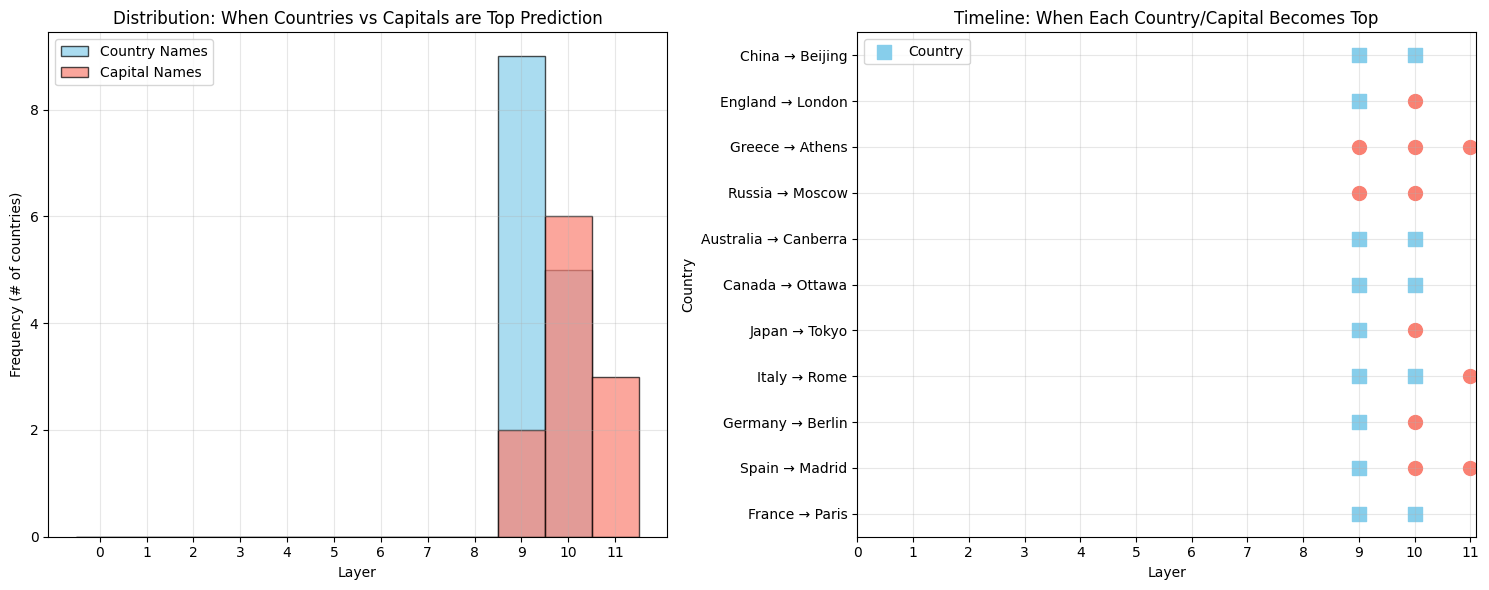


=== SUMMARY STATISTICS ===
Countries are top prediction in layers: [9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10]
Capitals are top prediction in layers: [9, 9, 10, 10, 10, 10, 10, 10, 11, 11, 11]
Country peak: Layer 9 (most common)
Capital range: Layers 9-11
Capital mean: Layer 10.1


In [ ]:
countries_capitals = {
    "France": "Paris",
    "Spain": "Madrid",
    "Germany": "Berlin",
    "Italy": "Rome",
    "Japan": "Tokyo",
    "Canada": "Ottawa",
    "Australia": "Canberra",
    "Russia": "Moscow",
    "Greece": "Athens",
    "England": "London",
    "China": "Beijing"
    }

# Run the analysis
print("Running analysis across all countries...")
results = analyze_country_capital_progression(countries_capitals, model)

# Create the visualization
plot_distribution(results)

In [ ]:
clean_prompt = 'The capital of England is'
corrupted_prompt = 'The capital of Spain is'

# Get activations
clean_tokens = model.to_tokens(clean_prompt, prepend_bos=False)
corrupted_tokens = model.to_tokens(corrupted_prompt, prepend_bos=False)

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)

# Predictions
print("Clean prediction:", model.to_string(clean_logits[0, -1].argmax()))
print("Corrupted prediction:", model.to_string(corrupted_logits[0, -1].argmax()))

# Target tokens
clean_token = model.to_single_token(" London")
corrupt_token = model.to_single_token(" Madrid")

print(f"\nClean logit: {clean_logits[0, -1, clean_token]:.3f}")
print(f"Corrupted logit: {corrupted_logits[0, -1, clean_token]:.3f}")

# Test patching at different layers
print("Patching residual stream at different layers:")
print(f"Original corrupted logit for Clean: {corrupted_logits[0, -1, clean_token]:.3f}")
print(f"Clean logit: {clean_logits[0, -1, clean_token]:.3f}")

for layer in [7, 8, 9, 10, 11]:
    patched_logits = patch_residual_stream(corrupted_cache, clean_cache, layer, corrupted_tokens)
    patched_clean_logit = patched_logits[0, -1, clean_token]

    print(f"Layer {layer} patched - Clean logit: {patched_clean_logit:.3f}")
    print(f"  Prediction: {model.to_string(patched_logits[0, -1].argmax())}")

Clean prediction:  the
Corrupted prediction:  Madrid

Clean logit: 13.485
Corrupted logit: 10.238
Patching residual stream at different layers:
Original corrupted logit for Clean: 10.238
Clean logit: 13.485
Layer 7 patched - Clean logit: 10.485
  Prediction:  the
Layer 8 patched - Clean logit: 10.930
  Prediction:  the
Layer 9 patched - Clean logit: 12.905
  Prediction:  the
Layer 10 patched - Clean logit: 13.568
  Prediction:  the
Layer 11 patched - Clean logit: 13.485
  Prediction:  the


In [ ]:
test_england_specific_patching()

Before patching:
Clean (England): Top = ' the'
Corrupted (Spain): Top = ' Madrid'

Testing England-specific patching:
Layer 8 patched: Top=' the', London rank=41
Layer 9 patched: Top=' the', London rank=7
Layer 10 patched: Top=' the', London rank=4
Layer 11 patched: Top=' the', London rank=5


In [ ]:
# Double-check the natural progression
prompt = "The capital of England is"
_, cache = model.run_with_cache(prompt, prepend_bos=False)
london_token = model.to_single_token(" London")

print("Natural England progression:")
for layer in [8, 9, 10, 11]:
    resid = cache["resid_post", layer][0, -1, :]
    logits = model.ln_final(resid) @ model.W_U + model.b_U
    top_token = model.to_string(logits.argmax())
    london_rank = get_token_rank(logits, london_token)
    print(f"Layer {layer}: Top='{top_token}', London rank={london_rank}")

Natural England progression:
Layer 8: Top=' now', London rank=65
Layer 9: Top=' England', London rank=5
Layer 10: Top=' London', London rank=1
Layer 11: Top=' the', London rank=5


In [ ]:
test_england_layer_10_patching()

Before patching:
Clean (England): Top = ' the'
Corrupted (Spain): Top = ' Madrid'
London rank in clean: 5
London rank in corrupted: 85

After patching Layer 10:
Top token: ' the'
London rank: 4


In [ ]:
# Since London is displaced in Layer 11 patching with the final clean cache doesn't get you london it goes back to "the"

In [ ]:
test_england_layer_10_specific()

Layer 10 analysis:
Clean Layer 10: Top=' London', London rank=1
Corrupted Layer 10: Top=' Madrid', London rank=71
Patched Layer 10 (should match clean): Top=' London', London rank=1
Final output after patching Layer 10: Top=' the', London rank=4


In [ ]:
## More insights! There are fragile and robust circuits, London is fragile because it doesn't stick it through to the end
# Madrid is robust because it does

In [ ]:
# Test Spain's Layer 10 vs final output
spain_prompt = "The capital of Spain is"
spain_tokens = model.to_tokens(spain_prompt, prepend_bos=False)

# Get both cache and final logits
spain_final_logits, spain_cache = model.run_with_cache(spain_tokens)

madrid_token = model.to_single_token(" Madrid")

# Layer 10 state
spain_resid_10 = spain_cache["resid_post", 10][0, -1, :]
spain_logits_10 = model.ln_final(spain_resid_10) @ model.W_U + model.b_U
spain_top_10 = model.to_string(spain_logits_10.argmax())

# Final state (from the returned logits)
spain_top_final = model.to_string(spain_final_logits[0, -1].argmax())

print(f"Spain Layer 10: '{spain_top_10}'")
print(f"Spain Final: '{spain_top_final}'")

# Also check Madrid ranks
madrid_rank_10 = get_token_rank(spain_logits_10, madrid_token)
madrid_rank_final = get_token_rank(spain_final_logits[0, -1], madrid_token)

print(f"Madrid rank at Layer 10: {madrid_rank_10}")
print(f"Madrid rank at Final: {madrid_rank_final}")

Spain Layer 10: ' Madrid'
Spain Final: ' Madrid'
Madrid rank at Layer 10: 1
Madrid rank at Final: 1


In [ ]:
# Test them all!
test_countries = [
    ("China", "Beijing"), ("Japan", "Tokyo"), ("Russia", "Moscow"),
    ("Italy", "Rome"), ("Greece", "Athens"), ("England", "London"),
    ("Canada", "Ottawa"), ("Australia", "Canberra"), ("Netherlands", "Amsterdam"), ("Germany", "Berlin"),
    ("France", "Paris"), ("Portugal", "Lisbon"), ("Spain", "Madrid")
]

In [ ]:
for test_country in test_countries:
    test_country_robustness(*test_country)

China→Beijing: Layer 10=' China', Final=' the' → 🔴 Non-Converging
Japan→Tokyo: Layer 10=' Tokyo', Final=' the' → 🟡 Fragile
Russia→Moscow: Layer 10=' Moscow', Final=' the' → 🟡 Fragile
Italy→Rome: Layer 10=' Italy', Final=' Rome' → 🟢 Converges
Greece→Athens: Layer 10=' Athens', Final=' Athens' → 🟢 Robust
England→London: Layer 10=' London', Final=' the' → 🟡 Fragile
Canada→Ottawa: Layer 10=' Canada', Final=' the' → 🔴 Non-Converging
Australia→Canberra: Layer 10=' Australia', Final=' the' → 🔴 Non-Converging
Netherlands→Amsterdam: Layer 10=' Amsterdam', Final=' the' → 🟡 Fragile
Germany→Berlin: Layer 10=' Berlin', Final=' the' → 🟡 Fragile
France→Paris: Layer 10=' France', Final=' the' → 🔴 Non-Converging
Portugal→Lisbon: Layer 10=' Lisbon', Final=' the' → 🟡 Fragile
Spain→Madrid: Layer 10=' Madrid', Final=' Madrid' → 🟢 Robust
